In [1]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.9 MB/s 


In [2]:
import pandas as pd
import datetime
import glob
import json
import pickle
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
import warnings
import statistics
from math import *
from scipy.stats import t, norm
from scipy import sqrt
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.model_selection import train_test_split, RepeatedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.exceptions import FitFailedWarning
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

# Import des données et sauvegarde

In [ ]:
# importer des données

def jeux_de_donnees(scen:str):
  scenario = []
  folder_path = f'drive/MyDrive/{scen}/'
  file_list = glob.glob(folder_path + "/*.csv")
  # création du jeu de données
  for file in file_list:
    scen_data = pd.read_csv(file)
    scenario.append(scen_data)
  # sauvegarder les données en csv
  with open(f"drive/MyDrive/save_data/{scen}.csv", "wb") as fp: #Pickling
    pickle.dump(scenario, fp)

jeux_de_donnees("scen1") # effet de statine = 0
jeux_de_donnees("scen2") # effet de statine = 0.8
jeux_de_donnees("scen3") # effet de statine = -0.8
jeux_de_donnees("scen4") # effet de statine = 0.2
jeux_de_donnees("scen5") # effet de statine = -0.2

In [ ]:
# restitution du jeux de données
Nsim=100
def open_data(scen:str):
 with open(f"drive/MyDrive/save_data/{scen}.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

scen1 = open_data("scen1")
scen2 = open_data("scen2")
scen3 = open_data("scen3")
scen4 = open_data("scen4")
scen5 = open_data("scen5")

# Taux de censure 

In [ ]:
# taux de censure 

## extrait des tables avant temps et statut vital
def extraction_table(scen:list):
  y=[]
  for k in range(len(scen)):
    scen[k] = scen[k].rename(columns = {'y': 'days'})
    vector_y = scen[k].iloc[:,50:52]
    y.append(vector_y)
  return y

## Comptage du nombre de vivant et mort pour chaque jeux de données
def statut_patient(table:list, scen:str):
  décès = []
  vivant = []
  for tab in table:
    d1=tab["failed"].value_counts()[1]
    décès.append(d1)
    d2=tab["failed"].value_counts()[0]
    vivant.append(d2)
    with open(f"drive/MyDrive/save_data/vivant/{scen}.csv", "wb") as fp: #Pickling
      pickle.dump(vivant, fp)
  return décès, vivant 

## taux de censure
def taux_censure(vivant:list):
  tx_censures=[]
  N=5000 #effectif 
  for nb_vivant in range(len(vivant)):
    tx_censure = vivant[nb_vivant]/N
    tx_censures.append(tx_censure)
  print(f"{statistics.mean(tx_censures)}±{statistics.stdev(tx_censures)}")

In [ ]:
y1 = extraction_table(scen1)
death1, life1 = statut_patient(scen1, "scen1")
taux_censure(life1)

0.800658±0.005727290331863279


In [ ]:
y2 = extraction_table(scen2)
death2, life2 = statut_patient(scen2, "scen2")
taux_censure(life2)

0.800426±0.005448058128703971


In [ ]:
y3 = extraction_table(scen3)
death3, life3 = statut_patient(scen3, "scen3")
taux_censure(life3)

0.800658±0.005727290331863279


In [ ]:
y4 = extraction_table(scen4)
death4, life4 = statut_patient(scen4, "scen4")
taux_censure(life4)

0.80039±0.005655166583833683


In [ ]:
y5 = extraction_table(scen5)
death5, life5 = statut_patient(scen5, "scen5")
taux_censure(life5)

0.800496±0.005155793446270521


# Modélisation 

## Transformation de variables

In [ ]:
# extraire les y et les transformer en dnarray
def transform_dnarray(y:list, cible:str):
  y2=[0 for k in range(len(y))]
  aux=[0 for k in range(len(y))]
  new_y=[0 for k in range(len(y))]
  for k in range(len(y)):
    y[k] = y[k].reindex(columns=["failed", "days"])
    y2[k]=y[k].to_numpy()
    aux[k] = [(e1,e2) for e1,e2 in y2[k]]
    new_y[k] = np.array(aux[k], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
    # sauvegarder les données en csv
    with open(f"drive/MyDrive/save_data/{cible}.csv", "wb") as fp: #Pickling
      pickle.dump(new_y, fp)

def extraction_variable_explicative(scen:list, explicative:str):
  X=[0 for i in range(len(scen))]
  for x in range(len(scen)):
    X[x] = scen[x].iloc[:,0:50]
  # sauvegarder les données en csv
  with open(f"drive/MyDrive/save_data/{explicative}.csv", "wb") as fp: #Pickling
    pickle.dump(X, fp)

In [ ]:
# séparation des variables explicatives et cibles du jeux de données du premier scénario
transform_dnarray(y1,"y1")
extraction_variable_explicative(scen1, "X1")

In [ ]:
# séparation des variables explicatives et cibles du jeux de données du deuxième scénario
transform_dnarray(y2,"y2")
extraction_variable_explicative(scen2, "X2")

In [ ]:
# séparation des variables explicatives et cibles du jeux de données du troisième scénario
transform_dnarray(y3,"y3")
extraction_variable_explicative(scen3, "X3")

In [ ]:
# séparation des variables explicatives et cibles du jeux de données du quatrième scénario
transform_dnarray(y4,"y4")
extraction_variable_explicative(scen4, "X4")

In [ ]:
# séparation des variables explicatives et cibles du jeux de données du cinquième scénario
transform_dnarray(y5,"y5")
extraction_variable_explicative(scen5, "X5")

In [ ]:
# restitution des tables 
def restitution_separate_table(X:str,y:str):
  with open(f"drive/MyDrive/save_data/{X}.csv", "rb") as fp:   # Unpickling
    X = pickle.load(fp)
  with open(f"drive/MyDrive/save_data/{y}.csv", "rb") as fp:   # Unpickling
    y = pickle.load(fp)
  return X,y

In [ ]:
X1,y1 = restitution_separate_table("X1", "y1")
X2,y2 = restitution_separate_table("X2", "y2")
X3,y3 = restitution_separate_table("X3", "y3")
X4,y4 = restitution_separate_table("X4", "y4")
X5,y5 = restitution_separate_table("X5", "y5")

## Matrice de corrélation

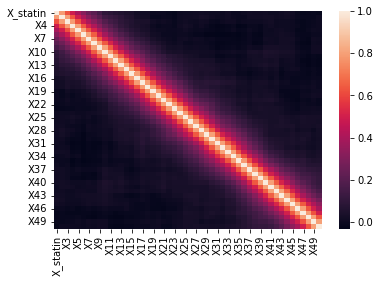

In [ ]:
# Etude de corrélation sur le 1er jeu de données de deuxième scénario (il est inutile de le faire sur les autres jeux de données du même scénario
# car ils sont construits de la même façon. De même, on s'intéresse à la corrélation, le taux de corrélation est le même pour chaque scénario)
X2[0].corr()
sns.heatmap(X2[0].corr())

## Modèle de Cox sans sélection de variable

In [ ]:
def estimator(scen:list, X:list, y, nom_scen:str):
  # coefficient des variables dans le modèle sans sélection de variables 
  estimator = CoxPHSurvivalAnalysis()
  list_coef = [] # on stocke la liste des coefficients de chaque modèle pour chaque dataframe
  coef_statin = [] # on stocke tous les coefficients de la variable X_statin pour chaque dataframe
  for data in range(len(scen)):
    estimator.fit(X[data], y[data])
    coef_statin.append(estimator.coef_[0])
    list_coef.append(estimator.coef_)
  # sauvegarder une liste dans un fichier
  with open(f"drive/MyDrive/save_data/coef_statin/{nom_scen}/cox_normal.csv", "wb") as fp:   #Pickling
    pickle.dump(coef_statin, fp)

In [ ]:
estimator(scen1, X1, y1, "scen1")

In [ ]:
estimator(scen2, X2, y2, "scen2")

In [ ]:
estimator(scen3, X3, y3, "scen3")

In [ ]:
estimator(scen4, X4, y4, "scen4")

In [ ]:
estimator(scen5, X5, y5, "scen5")

In [ ]:
def open_coef_statin(scen:str):
  with open(f"drive/MyDrive/save_data/coef_statin/{scen}/cox_normal.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
coef_statin1 = open_coef_statin("scen1")
coef_statin2 = open_coef_statin("scen2")
coef_statin3 = open_coef_statin("scen3")
coef_statin4 = open_coef_statin("scen4")
coef_statin5 = open_coef_statin("scen5")

## Boxplot de la distribution des coefficients de la statine

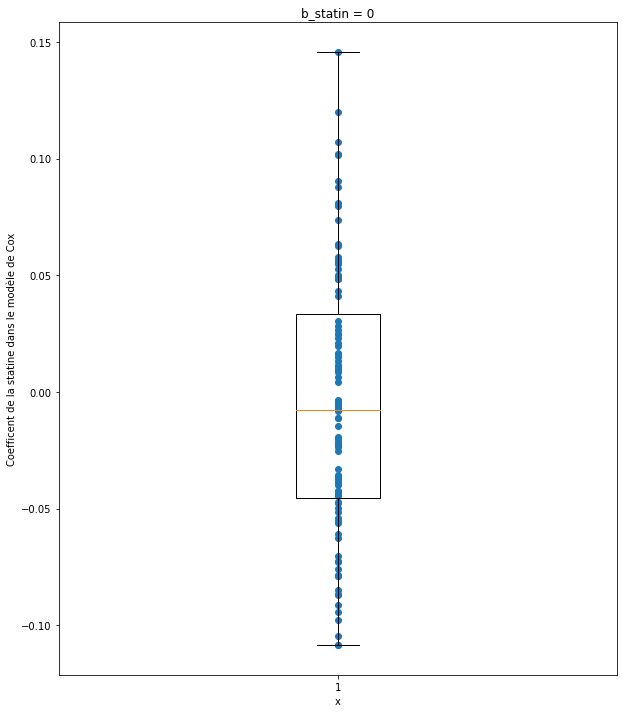

In [ ]:
# 1er scénario
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin1)
plt.scatter(x=[1 for i in range(len(list(coef_statin1)))],y=list(coef_statin1))
plt.title('b_statin = 0')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen1/coef_statine_normal1.png')

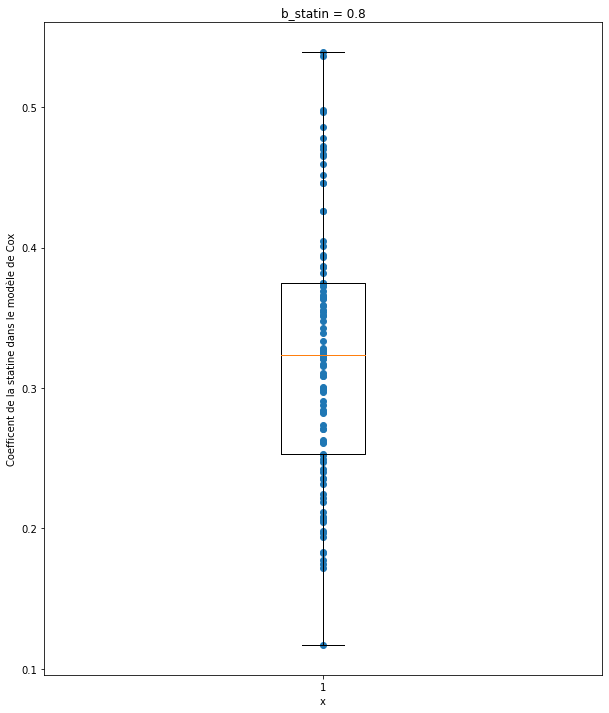

In [ ]:
# 2ème scénario
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin2)
plt.scatter(x=[1 for i in range(len(list(coef_statin2)))],y=list(coef_statin2))
plt.title('b_statin = 0.8')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen2/coef_statine_normal2.png')

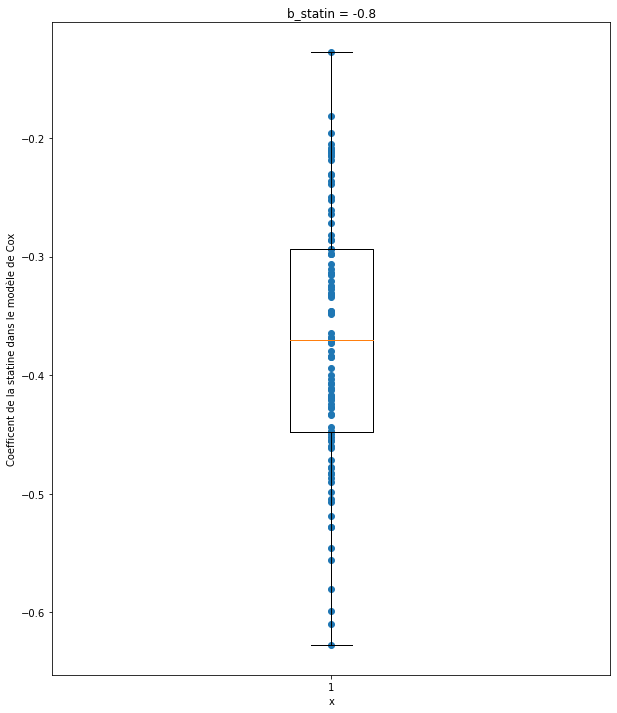

In [ ]:
# 3ème scénario
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin3)
plt.scatter(x=[1 for i in range(len(list(coef_statin3)))],y=list(coef_statin3))
plt.title('b_statin = -0.8')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen3/coef_statine_normal3.png')

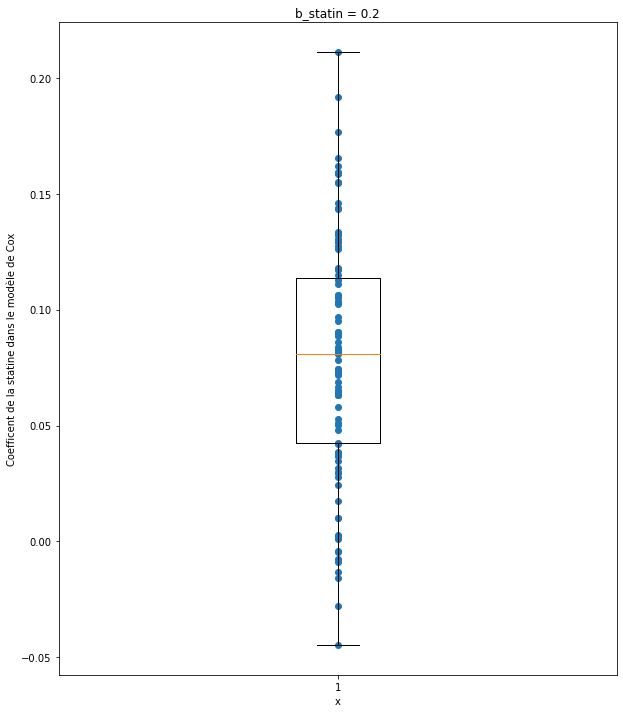

In [ ]:
# 4ème scénario
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin4)
plt.scatter(x=[1 for i in range(len(list(coef_statin4)))],y=list(coef_statin4))
plt.title('b_statin = 0.2')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen4/coef_statine_normal4.png')

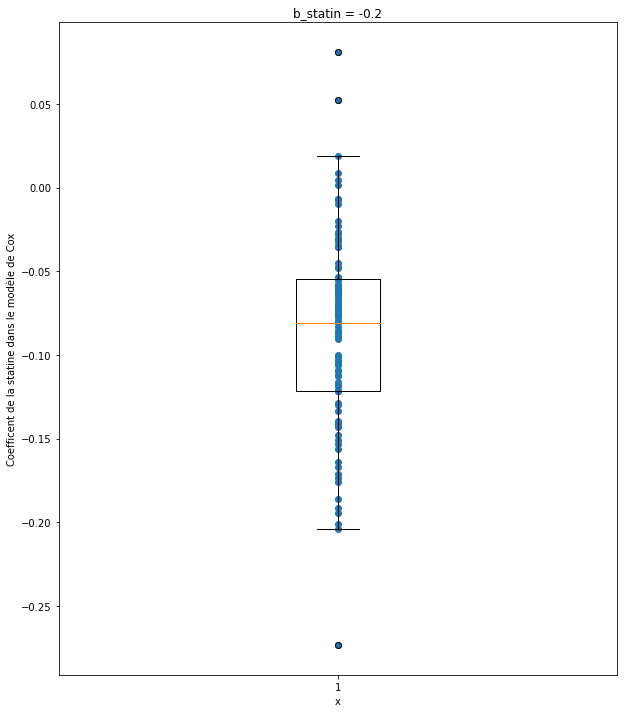

In [ ]:
# 5ème scénario
plt.figure(figsize =(10, 12))
plt.boxplot(coef_statin5)
plt.scatter(x=[1 for i in range(len(list(coef_statin5)))],y=list(coef_statin5))
plt.title('b_statin = -0.2')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen5/coef_statine_normal5.png')

In [ ]:
print(f"{statistics.mean(coef_statin1)}±{statistics.stdev(coef_statin1)}")

-0.0056681352400390385±0.05719303011311816


In [ ]:
print(f"{statistics.mean(coef_statin2)}±{statistics.stdev(coef_statin2)}")

0.32352348295068084±0.09103901837844326


In [ ]:
print(f"{statistics.mean(coef_statin3)}±{statistics.stdev(coef_statin3)}")

-0.36891474948227837±0.10814894974345174


In [ ]:
print(f"{statistics.mean(coef_statin4)}±{statistics.stdev(coef_statin4)}")

0.07923206841502706±0.05217873619759133


In [ ]:
print(f"{statistics.mean(coef_statin5)}±{statistics.stdev(coef_statin5)}")

-0.08746233220656138±0.05867894806458683


## Par pénalité Lasso

In [ ]:
# Choix de la valeur de alpha pour le Lasso
# Utilisation de l'échantillon d'alphas et performance sur 5 blocs pour la validation croisée avec la métrique du C-index pour chaque alpha
def model_lasso(scen:str, X:list, y, Nsim=100):
  list_cox_estimator = [ make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)) for k in range(Nsim)]
  list_estimated_alphas_lasso = []
  list_gcv_lasso = []
  for i in range(Nsim):
    list_cox_estimator[i].fit(X[i], y[i])
    list_estimated_alphas_lasso.append(list_cox_estimator[i].named_steps["coxnetsurvivalanalysis"].alphas_)
    cv_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
    list_gcv_lasso.append(GridSearchCV(
      list_cox_estimator[i],
      param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_lasso[i]]},
      cv=cv_lasso,
      error_score=0.5, # score utilisé par défaut
      n_jobs=4).fit(X[i], y[i]))
    with open(f"drive/MyDrive/save_data/Lasso/{scen}/gcv_lasso.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_gcv_lasso, fp)

In [ ]:
# restitution des tables 
def restitution_list_gcv_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/gcv_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
#model_lasso("scen1", X1, y1)
list_gcv_lasso1 = restitution_list_gcv_lasso("scen1")

In [ ]:
#model_lasso("scen2", X2, y2)
list_gcv_lasso2 = restitution_list_gcv_lasso("scen2")

In [ ]:
#model_lasso("scen3", X3, y3)
list_gcv_lasso3 = restitution_list_gcv_lasso("scen3")

In [ ]:
#model_lasso("scen4", X4, y4)
list_gcv_lasso4 = restitution_list_gcv_lasso("scen4")

In [ ]:
#model_lasso("scen5", X5, y5)
list_gcv_lasso5 = restitution_list_gcv_lasso("scen5")

In [ ]:
# évaluation des alphas dans chaque bloc pour le maximiser
def sortir_resultat(list_gcv_lasso:list, scen:str):
  list_cv_results_lasso = []
  for gcv_lasso in list_gcv_lasso:
    list_cv_results_lasso.append(pd.DataFrame(gcv_lasso.cv_results_))
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/cv_results_lasso.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_cv_results_lasso, fp)

In [ ]:
# restitution des tables 
def restitution_list_cv_result(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/cv_results_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#sortir_resultat(list_gcv_lasso1, "scen1")
list_cv_results_lasso1 = restitution_list_cv_result("scen1")

In [ ]:
list_cv_results_lasso1[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024873,0.012459,0.035151,0.018789,[0.07340710403922845],{'coxnetsurvivalanalysis__alphas': [0.07340710...,0.500000,0.603223,0.500000,0.598254,0.500000,0.540295,0.049377,6
1,0.035134,0.007467,0.040728,0.012815,[0.0700706378686602],{'coxnetsurvivalanalysis__alphas': [0.07007063...,0.664388,0.606038,0.652823,0.598254,0.661743,0.636649,0.028537,5
2,0.028225,0.005937,0.033967,0.002562,[0.06688581923483987],{'coxnetsurvivalanalysis__alphas': [0.06688581...,0.706272,0.639209,0.652823,0.618451,0.681380,0.659627,0.031008,4
3,0.031337,0.004498,0.034117,0.005420,[0.06384575552317881],{'coxnetsurvivalanalysis__alphas': [0.06384575...,0.744337,0.669011,0.654952,0.630280,0.696898,0.679095,0.039092,3
4,0.034333,0.002749,0.032508,0.005554,[0.060943867399059104],{'coxnetsurvivalanalysis__alphas': [0.06094386...,0.757656,0.706587,0.710591,0.653199,0.740377,0.713682,0.035677,2
5,0.036553,0.003155,0.020937,0.007121,[0.05817387456877533],{'coxnetsurvivalanalysis__alphas': [0.05817387...,0.774670,0.733260,0.741672,0.671340,0.774232,0.739035,0.037767,1


In [ ]:
# scénario 2
#sortir_resultat(list_gcv_lasso2, "scen2")
list_cv_results_lasso2 = restitution_list_cv_result("scen2")

In [ ]:
# scénario 3
#sortir_resultat(list_gcv_lasso3, "scen3")
list_cv_results_lasso3 = restitution_list_cv_result("scen3")

In [ ]:
# scénario 4
#sortir_resultat(list_gcv_lasso4, "scen4")
list_cv_results_lasso4 = restitution_list_cv_result("scen4")

In [ ]:
# scénario 5
#sortir_resultat(list_gcv_lasso5, "scen5")
list_cv_results_lasso5 = restitution_list_cv_result("scen5")

In [ ]:
# lister les valeurs de alphas, moyenne et std de alphas pour chaque blocs
def list_alphas_mean_std(list_cv_results_lasso:list, scen:str):
  list_alphas_lasso=[]
  list_mean_lasso=[]
  list_std_lasso=[]
  for cv_results_lasso in list_cv_results_lasso:
    list_alphas_lasso.append(cv_results_lasso.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0]))
    list_mean_lasso.append(cv_results_lasso.mean_test_score)
    list_std_lasso.append(cv_results_lasso.std_test_score)
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/alphas_lasso.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_alphas_lasso, fp)
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/mean_lasso.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_mean_lasso, fp)
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/std_lasso.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_std_lasso, fp)

In [ ]:
# retourner les résultats de lasso 
## alphas_lasso
def restitution_list_alphas_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/alphas_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## mean_lasso
def restitution_list_mean_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/mean_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## std_lasso
def restitution_list_std_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/std_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#list_alphas_mean_std(list_cv_results_lasso1, "scen1")
list_alphas_lasso1 = restitution_list_alphas_lasso("scen1")
list_mean_lasso1 = restitution_list_mean_lasso("scen1")
list_std_lasso1 = restitution_list_std_lasso("scen1")

# scénario 2
#list_alphas_mean_std(list_cv_results_lasso2, "scen2")
list_alphas_lasso2 = restitution_list_alphas_lasso("scen2")
list_mean_lasso2 = restitution_list_mean_lasso("scen2")
list_std_lasso2 = restitution_list_std_lasso("scen2")

# scénario 3
#list_alphas_mean_std(list_cv_results_lasso3, "scen3")
list_alphas_lasso3 = restitution_list_alphas_lasso("scen3")
list_mean_lasso3 = restitution_list_mean_lasso("scen3")
list_std_lasso3 = restitution_list_std_lasso("scen3")

# scénario 4
#list_alphas_mean_std(list_cv_results_lasso4, "scen4")
list_alphas_lasso4 = restitution_list_alphas_lasso("scen4")
list_mean_lasso4 = restitution_list_mean_lasso("scen4")
list_std_lasso4 = restitution_list_std_lasso("scen4")

# scénario 5
#list_alphas_mean_std(list_cv_results_lasso5, "scen5")
list_alphas_lasso5 = restitution_list_alphas_lasso("scen5")
list_mean_lasso5 = restitution_list_mean_lasso("scen5")
list_std_lasso5 = restitution_list_std_lasso("scen5")

In [ ]:
def selection_variable_function(list_gcv_lasso:list, X:list, scen:str): 
  # sélection de variable 
  list_best_model_lasso = []
  list_best_coefs_lasso = []
  list_non_zero_lasso = []
  list_non_zero_coefs_lasso = []
  list_coef_order_lasso = []

  for gcv_lasso in list_gcv_lasso:
    list_best_model_lasso.append(gcv_lasso.best_estimator_.named_steps["coxnetsurvivalanalysis"])
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/best_model_lasso.csv", "wb") as fp:   # pickling
    pickle.dump(list_best_model_lasso, fp)
  for  k in range(len(list_best_model_lasso)):
    list_best_coefs_lasso.append(pd.DataFrame(
    list_best_model_lasso[k].coef_,
    index=X[k].columns,
    columns=["coefficient"]))
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/best_coefs_lasso.csv", "wb") as fp:   # pickling
    pickle.dump(list_best_coefs_lasso, fp)
  # Donner le nombre de variable sélectionné pour chaque jeu de données et extraire les coefficients des variables sélectionnés 
  for best_coefs_lasso in list_best_coefs_lasso:
    list_non_zero_lasso.append(np.sum(best_coefs_lasso.iloc[:, 0] != 0))
    list_non_zero_coefs_lasso.append(best_coefs_lasso.query("coefficient != 0"))
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/nb_variable_selectionné.csv", "wb") as fp:   # pickling
    pickle.dump(list_non_zero_lasso, fp)
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/coefficient_variable_selectionné.csv", "wb") as fp:   # pickling
    pickle.dump(list_non_zero_coefs_lasso, fp)
  # Réordonner les variables sélectionnés par ordre croissant de leur coefficients (et cela pour chaque jeux de données)
  for non_zero_coefs_lasso in list_non_zero_coefs_lasso:
    list_coef_order_lasso.append(non_zero_coefs_lasso.abs().sort_values("coefficient").index)

In [ ]:
# retourner les résultats de lasso 

## best_model_lasso
def restitution_list_best_model_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/best_model_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)
  
## best_coefs_lasso
def restitution_list_best_coefs_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/best_coefs_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## nombre de variable sélectionnées
def restitution_list_nb_variable_selected(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/nb_variable_selectionné.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## coefficient des variables selectionnées
def restitution_list_coefficient_variable_selected(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/coefficient_variable_selectionné.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
selection_variable_function(list_gcv_lasso1, X1, "scen1") #scénario 1
selection_variable_function(list_gcv_lasso2, X2, "scen2") #scénario 2
selection_variable_function(list_gcv_lasso3, X3, "scen3") #scénario 3
selection_variable_function(list_gcv_lasso4, X4, "scen4") #scénario 4
selection_variable_function(list_gcv_lasso5, X5, "scen5") #scénario 5

In [ ]:
# scénario 1
list_best_model_lasso1 = restitution_list_best_model_lasso("scen1")
list_best_coefs_lasso1 = restitution_list_best_coefs_lasso("scen1")
list_non_zero_lasso1 = restitution_list_nb_variable_selected("scen1")
list_non_zero_coefs_lasso1 = restitution_list_coefficient_variable_selected("scen1")

In [ ]:
# scénario 2
#selection_variable_function(list_gcv_lasso2, X2, "scen2")
list_best_model_lasso2 = restitution_list_best_model_lasso("scen2")
list_best_coefs_lasso2 = restitution_list_best_coefs_lasso("scen2")
list_non_zero_lasso2 = restitution_list_nb_variable_selected("scen2")
list_non_zero_coefs_lasso2 = restitution_list_coefficient_variable_selected("scen2")

In [ ]:
# scénario 3
#selection_variable_function(list_gcv_lasso3, X3, "scen3")
list_best_model_lasso3 = restitution_list_best_model_lasso("scen3")
list_best_coefs_lasso3 = restitution_list_best_coefs_lasso("scen3")
list_non_zero_lasso3 = restitution_list_nb_variable_selected("scen3")
list_non_zero_coefs_lasso3 = restitution_list_coefficient_variable_selected("scen3")

In [ ]:
# scénario 4
#selection_variable_function(list_gcv_lasso4, X4, "scen4")
list_best_model_lasso4 = restitution_list_best_model_lasso("scen4")
list_best_coefs_lasso4 = restitution_list_best_coefs_lasso("scen4")
list_non_zero_lasso4 = restitution_list_nb_variable_selected("scen4")
list_non_zero_coefs_lasso4 = restitution_list_coefficient_variable_selected("scen4")

In [ ]:
# scénario 5
#selection_variable_function(list_gcv_lasso5, X5, "scen5")
list_best_model_lasso5 = restitution_list_best_model_lasso("scen5")
list_best_coefs_lasso5 = restitution_list_best_coefs_lasso("scen5")
list_non_zero_lasso5 = restitution_list_nb_variable_selected("scen5")
list_non_zero_coefs_lasso5 = restitution_list_coefficient_variable_selected("scen5")

In [ ]:
# sélectionner les modèles qui ont sélectionné X_statin et énumérer les coefficients de X_statin
def model_selected_statin(list_best_coefs_lasso:list):
  list_best_coefs_lasso_statin = []
  list_coef_xstatin = []
  non_zero_coefs_lasso_statin = []
  count=0
  for i , best_coefs_lasso in enumerate(list_best_coefs_lasso):
    non_zero_coefs_lasso_statin.append(best_coefs_lasso.query("coefficient != 0"))
    if best_coefs_lasso.iloc[0,0] !=0:
      list_coef_xstatin.append(best_coefs_lasso.iloc[0,0])
      list_best_coefs_lasso_statin.append(best_coefs_lasso)
      count=count+1
      print(f"la table {i+1} sélectionne X_statin")
    else:
      print(f"la table {i+1} ne sélectionne pas X_statin")
  return list_best_coefs_lasso_statin, list_coef_xstatin, non_zero_coefs_lasso_statin, count

In [ ]:
# 1er scénario
list_best_coefs_lasso_statin1, list_coef_xstatin1, non_zero_coefs_lasso_statin1, count_lasso1 = model_selected_statin(list_best_coefs_lasso1)

In [ ]:
# 2ème scénario
list_best_coefs_lasso_statin2, list_coef_xstatin2, non_zero_coefs_lasso_statin2, count_lasso2 = model_selected_statin(list_best_coefs_lasso2)

la table 1 ne sélectionne pas X_statin
la table 2 sélectionne X_statin
la table 3 ne sélectionne pas X_statin
la table 4 ne sélectionne pas X_statin
la table 5 ne sélectionne pas X_statin
la table 6 ne sélectionne pas X_statin
la table 7 ne sélectionne pas X_statin
la table 8 ne sélectionne pas X_statin
la table 9 ne sélectionne pas X_statin
la table 10 ne sélectionne pas X_statin
la table 11 ne sélectionne pas X_statin
la table 12 sélectionne X_statin
la table 13 sélectionne X_statin
la table 14 ne sélectionne pas X_statin
la table 15 ne sélectionne pas X_statin
la table 16 ne sélectionne pas X_statin
la table 17 ne sélectionne pas X_statin
la table 18 ne sélectionne pas X_statin
la table 19 ne sélectionne pas X_statin
la table 20 ne sélectionne pas X_statin
la table 21 ne sélectionne pas X_statin
la table 22 ne sélectionne pas X_statin
la table 23 sélectionne X_statin
la table 24 ne sélectionne pas X_statin
la table 25 sélectionne X_statin
la table 26 ne sélectionne pas X_statin
la t

In [ ]:
# 3ème scénario 
list_best_coefs_lasso_statin3, list_coef_xstatin3, non_zero_coefs_lasso_statin3, count_lasso3 = model_selected_statin(list_best_coefs_lasso3)

In [ ]:
# 4ème scénario
list_best_coefs_lasso_statin4, list_coef_xstatin4, non_zero_coefs_lasso_statin4, count_lasso4 = model_selected_statin(list_best_coefs_lasso4)

In [ ]:
# 5ème scénario 
list_best_coefs_lasso_statin5, list_coef_xstatin5, non_zero_coefs_lasso_statin5, count_lasso5 = model_selected_statin(list_best_coefs_lasso5)

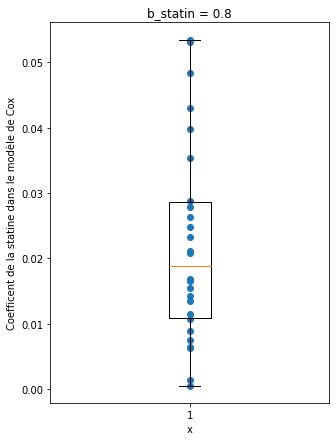

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin2)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin2)))],y=list(list_coef_xstatin2))
plt.title('b_statin = 0.8')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen2/coef_statine_lasso2.png')

In [ ]:
print(f"{statistics.mean(list_coef_xstatin2)}±{statistics.stdev(list_coef_xstatin2)}")

0.02215349609164899±0.015392270672023426


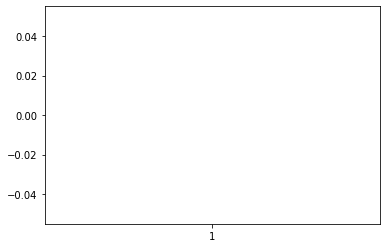

In [ ]:
plt.boxplot(list_coef_xstatin5)
plt.savefig('drive/MyDrive/save_data/coef_statin/scen5/coef_statine_lasso5.png')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc2f2f1a450>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc2f2da7950>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc2f2f9be50>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc2f180b250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2f136ad10>,
 'means': []}

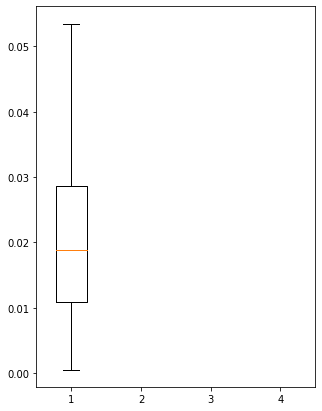

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot([list_coef_xstatin2, list_coef_xstatin3, list_coef_xstatin4, list_coef_xstatin5])

## Par pénalité Elastic-net

In [ ]:
def model_elastic_net(scen:list, X:list, y:list, nom_scen:str):
  # Choix de la valeur de alpha
  # Utilisation de l'échantillon d'alphas et performance sur 5 blocs pour la validation croisée avec la métrique du C-index pour chaque alpha
  list_cox_estimator_elastic_net = [make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)) for k in range(Nsim)]
  list_estimated_alphas_elastic_net=[]
  list_gcv_elastic_net=[]
  for i in range(Nsim):
    list_cox_estimator_elastic_net[i].fit(X[i], y[i])
    list_estimated_alphas_elastic_net.append(list_cox_estimator_elastic_net[i].named_steps["coxnetsurvivalanalysis"].alphas_)
    cv_elastic_net = KFold(n_splits=5, shuffle=True, random_state=0)
    list_gcv_elastic_net.append(GridSearchCV(
      list_cox_estimator_elastic_net[i],
      param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_elastic_net[i]], "coxnetsurvivalanalysis__l1_ratio": np.arange(0,1.1,0.1)},
      cv=cv_elastic_net,
      error_score=0.5, # score utilisé par défaut
      n_jobs=4).fit(X[i], y[i]))
    # sauvegarder une liste dans un fichier
  with open(f"drive/MyDrive/save_data/Elastic-net/{nom_scen}/gcv_elastic_net.csv", "wb") as fp:   #Pickling
    pickle.dump(list_gcv_elastic_net, fp)

In [ ]:
# restitution des tables 
def restitution_list_gcv_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/gcv_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#model_elastic_net(scen1, X1, y1, "scen1")
list_gcv_elastic_net1 = restitution_list_gcv_elastic_net("scen1")

In [ ]:
# scénario 2
#model_elastic_net(scen2, X2, y2, "scen2")
list_gcv_elastic_net2 = restitution_list_gcv_elastic_net("scen2")

In [ ]:
# scénario 3
#model_elastic_net(scen3, X3, y3, "scen3")
list_gcv_elastic_net3 = restitution_list_gcv_elastic_net("scen3")

In [ ]:
# scénario 4
#model_elastic_net(scen4, X4, y4, "scen4")
list_gcv_elastic_net4 = restitution_list_gcv_elastic_net("scen4")

In [ ]:
# scénario 5
#model_elastic_net(scen5, X5, y5, "scen5")
list_gcv_elastic_net5 = restitution_list_gcv_elastic_net("scen2")

In [ ]:
def sortie_results_elastic_net(list_gcv_elastic_net:list, scen:str):
  # évaluation des alphas dans chaque bloc pour le maximiser
  list_cv_results_elastic_net = []
  for gcv_elastic_net in list_gcv_elastic_net:
    list_cv_results_elastic_net.append(pd.DataFrame(gcv_elastic_net.cv_results_))
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/cv_results_elastic_net.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_cv_results_elastic_net, fp)

In [ ]:
# restitution des tables élastic-net
def restitution_list_cv_result_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/cv_results_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#sortie_results_elastic_net(list_gcv_elastic_net1, "scen1")
list_cv_results_elastic_net1 = restitution_list_cv_result_elastic_net("scen1")

In [ ]:
# scénario 2
#sortie_results_elastic_net(list_gcv_elastic_net2, "scen2")
list_cv_results_elastic_net2 = restitution_list_cv_result_elastic_net("scen2")

In [ ]:
# scénario 3
#sortie_results_elastic_net(list_gcv_elastic_net3, "scen3")
list_cv_results_elastic_net3 = restitution_list_cv_result_elastic_net("scen3")

In [ ]:
# scénario 4
#sortie_results_elastic_net(list_gcv_elastic_net4, "scen4")
list_cv_results_elastic_net4 = restitution_list_cv_result_elastic_net("scen4")

In [ ]:
# scénario 5
#sortie_results_elastic_net(list_gcv_elastic_net5, "scen5")
list_cv_results_elastic_net5 = restitution_list_cv_result_elastic_net("scen5")

In [ ]:
def list_alphas_lambda_mean_std(list_cv_results_elastic_net:list, scen:str):
  # lister les valeurs de alphas, moyenne et écart-type de alphas pour chaque blocs
  list_alphas_elastic_net=[]
  list_l1_ratio_elastic_net=[]
  list_mean_elastic_net=[]
  list_std_elastic_net=[]
  for cv_results_elastic_net in list_cv_results_elastic_net:
    list_alphas_elastic_net.append(cv_results_elastic_net.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0]))
    list_l1_ratio_elastic_net.append(cv_results_elastic_net.param_coxnetsurvivalanalysis__l1_ratio)
    list_mean_elastic_net.append(cv_results_elastic_net.mean_test_score)
    list_std_elastic_net.append(cv_results_elastic_net.std_test_score)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/alphas_elastic_net.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_alphas_elastic_net, fp)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/l1_ratio_elastic_net.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_l1_ratio_elastic_net, fp)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/mean_elastic_net.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_mean_elastic_net, fp)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/std_elastic_net.csv", "wb") as fp:   # Unpickling
      pickle.dump(list_std_elastic_net, fp)

In [ ]:
# retourner les résultats de élastic-net
## alphas_lasso
def restitution_list_alphas_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/alphas_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## l1_ratio
def restitution_list_l1_ratio_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/l1_ratio_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## mean_lasso
def restitution_list_mean_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/mean_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## std_lasso
def restitution_list_std_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/std_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#list_alphas_lambda_mean_std(list_cv_results_elastic_net1, "scen1")
list_l1_ratio_elastic_net1 = restitution_list_l1_ratio_elastic_net("scen1")
list_alphas_elastic_net1 = restitution_list_alphas_elastic_net("scen1")
list_mean_elastic_net1 = restitution_list_mean_elastic_net("scen1")
list_std_elastic_net1 = restitution_list_std_elastic_net("scen1")

In [ ]:
# scénario 2
#list_alphas_lambda_mean_std(list_cv_results_elastic_net2, "scen2")
list_l1_ratio_elastic_net2 = restitution_list_l1_ratio_elastic_net("scen2")
list_alphas_elastic_net2 = restitution_list_alphas_elastic_net("scen2")
list_mean_elastic_net2 = restitution_list_mean_elastic_net("scen2")
list_std_elastic_net2 = restitution_list_std_elastic_net("scen2")

In [ ]:
# scénario 3
#list_alphas_lambda_mean_std(list_cv_results_elastic_net3, "scen3")
list_l1_ratio_elastic_net3 = restitution_list_l1_ratio_elastic_net("scen3")
list_alphas_elastic_net3 = restitution_list_alphas_elastic_net("scen3")
list_mean_elastic_net3 = restitution_list_mean_elastic_net("scen3")
list_std_elastic_net3 = restitution_list_std_elastic_net("scen3")

In [ ]:
# scénario 4
#list_alphas_lambda_mean_std(list_cv_results_elastic_net4, "scen4")
list_l1_ratio_elastic_net4 = restitution_list_l1_ratio_elastic_net("scen4")
list_alphas_elastic_net4 = restitution_list_alphas_elastic_net("scen4")
list_mean_elastic_net4 = restitution_list_mean_elastic_net("scen4")
list_std_elastic_net4 = restitution_list_std_elastic_net("scen4")

In [ ]:
# scénario 5
#list_alphas_lambda_mean_std(list_cv_results_elastic_net5, "scen5")
list_l1_ratio_elastic_net5 = restitution_list_l1_ratio_elastic_net("scen5")
list_alphas_elastic_net5 = restitution_list_alphas_elastic_net("scen5")
list_mean_elastic_net5 = restitution_list_mean_elastic_net("scen5")
list_std_elastic_net5 = restitution_list_std_elastic_net("scen5")

In [ ]:
def selection_variable_function_elastic_net(list_gcv_elastic_net:list, X:list, scen:str):
  # sélection de variable 
  list_best_model_elastic_net = []
  list_best_coefs_elastic_net = []
  list_non_zero_elastic_net = []
  list_non_zero_coefs_elastic_net = []
  list_coef_order_elastic_net = []

  for gcv_elastic_net in list_gcv_elastic_net:
    list_best_model_elastic_net.append(gcv_elastic_net.best_estimator_.named_steps["coxnetsurvivalanalysis"])
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/best_model_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_best_model_elastic_net, fp)

  for  k in range(len(list_best_model_elastic_net)):
      list_best_coefs_elastic_net.append(pd.DataFrame(
      list_best_model_elastic_net[k].coef_,
      index=X[k].columns,
      columns=["coefficient"]))
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/best_coefs_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_best_coefs_elastic_net, fp)

  # Donner le nombre de variable sélectionné pour chaque jeu de données et extraire les coefficients des variables sélectionnés 
  for best_coefs_elastic_net in list_best_coefs_elastic_net:
    list_non_zero_elastic_net.append(np.sum(best_coefs_elastic_net.iloc[:, 0] != 0))
    list_non_zero_coefs_elastic_net.append(best_coefs_elastic_net.query("coefficient != 0"))
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/nb_variable_selectionné.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_non_zero_elastic_net, fp)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/coefficient_variable_selectionné.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_non_zero_coefs_elastic_net, fp)

  # Réordonner les variables sélectionnés par ordre croissant de leur coefficients (et cela pour chaque jeux de données)
  for non_zero_coefs_elastic_net in list_non_zero_coefs_elastic_net:
    list_coef_order_elastic_net.append(non_zero_coefs_elastic_net.abs().sort_values("coefficient").index)

In [ ]:
# retourner les résultats de Elastic-net 2

## best_model_elastic_net
def restitution_list_best_model_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/best_model_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)
  
## best_coefs_elastic_net
def restitution_list_best_coefs_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/best_coefs_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## nombre de variable sélectionnées pour l'élastic-net
def restitution_list_nb_variable_selected_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/nb_variable_selectionné.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## coefficient des variables selectionnées pour l'élastic-net
def restitution_list_coefficient_variable_selected_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/coefficient_variable_selectionné.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#selection_variable_function_elastic_net(list_gcv_elastic_net1, X1, "scen1")
list_best_model_elastic_net1 = restitution_list_best_model_elastic_net("scen1")
list_best_coefs_elastic_net1 = restitution_list_best_coefs_elastic_net("scen1")
list_non_zero_elastic_net1 = restitution_list_nb_variable_selected_elastic_net("scen1")
list_non_zero_coefs_elastic_net1 = restitution_list_coefficient_variable_selected_elastic_net("scen1")

In [ ]:
# scénario 2
#selection_variable_function_elastic_net(list_gcv_elastic_net2, X2, "scen2")
list_best_model_elastic_net2 = restitution_list_best_model_elastic_net("scen2")
list_best_coefs_elastic_net2 = restitution_list_best_coefs_elastic_net("scen2")
list_non_zero_elastic_net2 = restitution_list_nb_variable_selected_elastic_net("scen2")
list_non_zero_coefs_elastic_net2 = restitution_list_coefficient_variable_selected_elastic_net("scen2")

In [ ]:
# scénario 3
#selection_variable_function_elastic_net(list_gcv_elastic_net3, X3, "scen3")
list_best_model_elastic_net3 = restitution_list_best_model_elastic_net("scen3")
list_best_coefs_elastic_net3 = restitution_list_best_coefs_elastic_net("scen3")
list_non_zero_lasso3 = restitution_list_nb_variable_selected_elastic_net("scen3")
list_non_zero_coefs_lasso3 = restitution_list_coefficient_variable_selected_elastic_net("scen3")

In [ ]:
# scénario 4
#selection_variable_function_elastic_net(list_gcv_elastic_net4, X4, "scen4")
list_best_model_elastic_net4 = restitution_list_best_model_elastic_net("scen4")
list_best_coefs_elastic_net4 = restitution_list_best_coefs_elastic_net("scen4")
list_non_zero_lasso4 = restitution_list_nb_variable_selected_elastic_net("scen4")
list_non_zero_coefs_lasso4 = restitution_list_coefficient_variable_selected_elastic_net("scen4")

In [ ]:
# scénario 5
#selection_variable_function_elastic_net(list_gcv_elastic_net5, X5, "scen5")
list_best_model_elastic_net5 = restitution_list_best_model_elastic_net("scen5")
list_best_coefs_elastic_net5 = restitution_list_best_coefs_elastic_net("scen5")
list_non_zero_lasso5 = restitution_list_nb_variable_selected_elastic_net("scen5")
list_non_zero_coefs_lasso5 = restitution_list_coefficient_variable_selected_elastic_net("scen5")

In [ ]:
# sélectionner les modèles qui ont sélectionné X_statin et énumérer les coefficients de X_statin
def model_selected_statin_elastic_net(list_best_coefs_elastic_net:list):  
  list_best_coefs_elastic_net_statin=[]
  list_coef_xstatin_elastic_net = []
  non_zero_coefs_elastic_net_statin = []
  count = 0
  for i , best_coefs_elastic_net in enumerate(list_best_coefs_elastic_net):
    non_zero_coefs_elastic_net_statin.append(best_coefs_elastic_net.query("coefficient != 0"))
    if best_coefs_elastic_net.iloc[0,0] !=0:
      list_coef_xstatin_elastic_net.append(best_coefs_elastic_net.iloc[0,0])
      list_best_coefs_elastic_net_statin.append(best_coefs_elastic_net)
      count=count+1
      print(f"la table {i+1} sélectionne X_statin")
    else:
      print(f"la table {i+1} ne sélectionne pas X_statin")
  return list_best_coefs_elastic_net_statin, list_coef_xstatin_elastic_net, non_zero_coefs_elastic_net_statin, count

In [ ]:
# 1er scénario
list_best_coefs_elastic_net_statin1, list_coef_xstatin_elastic_net1, non_zero_coefs_elastic_net_statin1, count_elastic_net1 = model_selected_statin_elastic_net(list_best_coefs_elastic_net1)

In [ ]:
# 2ème scénario
list_best_coefs_elastic_net_statin2, list_coef_xstatin_elastic_net2, non_zero_coefs_elastic_net_statin2, count_elastic_net2 = model_selected_statin_elastic_net(list_best_coefs_elastic_net2)

In [ ]:
# 3ème scénario
list_best_coefs_elastic_net_statin3, list_coef_xstatin_elastic_net3, non_zero_coefs_elastic_net_statin3, count_elastic_net3 = model_selected_statin_elastic_net(list_best_coefs_elastic_net3)

In [ ]:
# 4ème scénario
list_best_coefs_elastic_net_statin4, list_coef_xstatin_elastic_net4, non_zero_coefs_elastic_net_statin4, count_elastic_net4 = model_selected_statin_elastic_net(list_best_coefs_elastic_net4)

In [ ]:
# 5ème scénario
list_best_coefs_elastic_net_statin5, list_coef_xstatin_elastic_net5, non_zero_coefs_elastic_net_statin5, count_elastic_net5 = model_selected_statin_elastic_net(list_best_coefs_elastic_net5)

In [ ]:
print(f"{statistics.mean(list_coef_xstatin_elastic_net5)}±{statistics.stdev(list_coef_xstatin_elastic_net5)}")

0.17087679464816757±0.04112593787568593


**Traçage des boxplots de la statine**

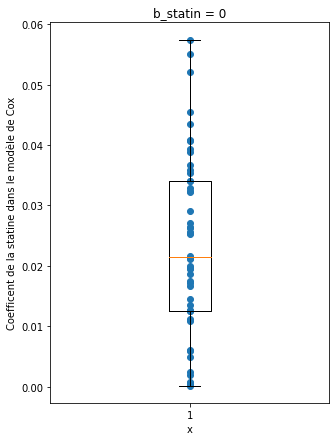

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin_elastic_net1)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin_elastic_net1)))],y=list(list_coef_xstatin_elastic_net1))
plt.title('b_statin = 0')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen1/coef_statine_elastic-net1.png')

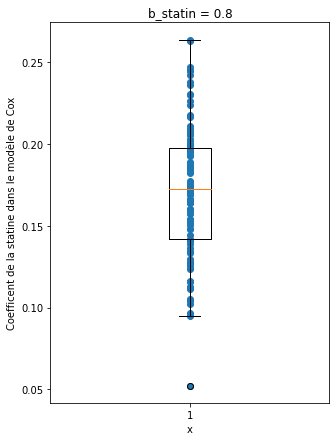

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin_elastic_net2)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin_elastic_net2)))],y=list(list_coef_xstatin_elastic_net2))
plt.title('b_statin = 0.8')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen2/coef_statine_elastic-net2.png')

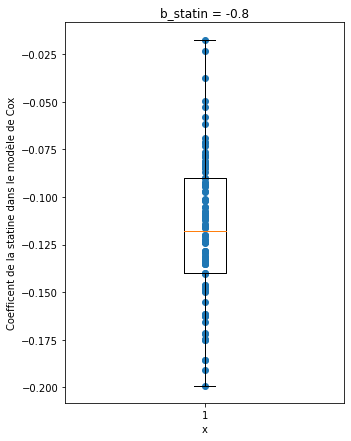

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin_elastic_net3)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin_elastic_net3)))],y=list(list_coef_xstatin_elastic_net3))
plt.title('b_statin = -0.8')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen3/coef_statine_elastic-net3.png')

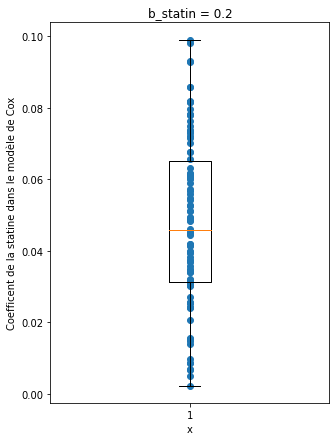

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin_elastic_net4)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin_elastic_net4)))],y=list(list_coef_xstatin_elastic_net4))
plt.title('b_statin = 0.2')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen4/coef_statine_elastic-net4.png')

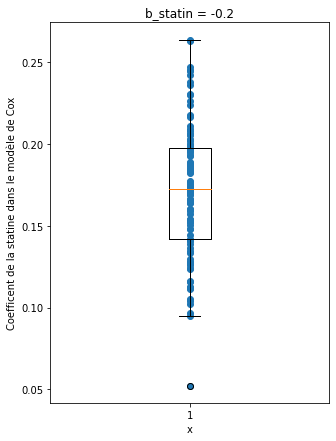

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot(list_coef_xstatin_elastic_net5)
plt.scatter(x=[1 for i in range(len(list(list_coef_xstatin_elastic_net5)))],y=list(list_coef_xstatin_elastic_net5))
plt.title('b_statin = -0.2')
plt.xlabel('x')
plt.ylabel('Coefficent de la statine dans le modèle de Cox')
plt.savefig('drive/MyDrive/save_data/coef_statin/scen5/coef_statine_elastic-net5.png')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


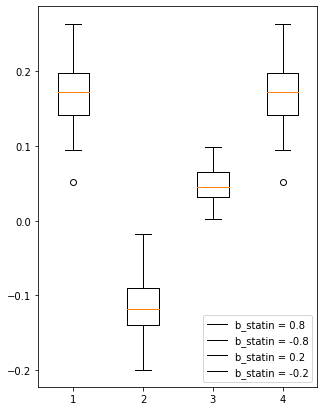

In [ ]:
plt.figure(figsize =(5, 7))
plt.boxplot([list_coef_xstatin_elastic_net2, list_coef_xstatin_elastic_net3, list_coef_xstatin_elastic_net4, list_coef_xstatin_elastic_net5])
plt.legend(["b_statin = 0.8", "b_statin = -0.8", "b_statin = 0.2", "b_statin = -0.2"])


## Evaluation de la performance du modèle 

### C-index (indice de concordance)

In [5]:
# declare the outer validation cross strategie
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# create model
model = CoxPHSurvivalAnalysis()
Nsim=100

In [6]:
# calcul du c-index moyen
def c_index_mean(test_score:list):
  # calcul de la moyenne des C-index pour chaque modèle
  C_index_mean = []
  for i in range(Nsim):
    C_index_mean.append(statistics.mean(list(test_score[i])))
  return statistics.mean(C_index_mean)

***Sans sélection de variable***

In [ ]:
# c'est là, qu'on évalue le modèle 
def calcul_test_score(list_model:list, X:list, y:list, scen:str):
  test_score_normal = []
  for k in range(Nsim):
    test_score_normal.append(cross_val_score(model, X[k], y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n "
      #f"{test_score_normal[k].mean():.3f} ± {test_score_normal[k].std():.3f}")
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/test_score_normal.csv", "wb") as fp:   # Unpickling
    pickle.dump(test_score_normal, fp)

In [ ]:
# retourner les résultats
def restitution_list_test_score_normal(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/test_score_normal.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

In [ ]:
# scénario 1
#calcul_test_score(model, X1, y1, "scen1")
test_score_normal1 = restitution_list_test_score_normal("scen1")
c_index_mean(test_score_normal1)

0.8253390242712194

In [ ]:
# scénario 2
#calcul_test_score(model, X2, y2, "scen2")
test_score_normal2 = restitution_list_test_score_normal("scen2")
c_index_mean(test_score_normal2)

0.8218581431340157

In [ ]:
# scénario 3
#calcul_test_score(model, X3, y3, "scen3")
test_score_normal3 = restitution_list_test_score_normal("scen3")
c_index_mean(test_score_normal3)

0.8256207022206183

In [ ]:
# scénario 4
#calcul_test_score(model, X4, y4, "scen4")
test_score_normal4 = restitution_list_test_score_normal("scen4")
c_index_mean(test_score_normal4)

0.8224700695594116

In [ ]:
# scénario 5
#calcul_test_score(model, X5, y5, "scen5")
test_score_normal5 = restitution_list_test_score_normal("scen5")
c_index_mean(test_score_normal5)

0.8278218854880832

***Avec pénalité de Lasso***

In [ ]:
def calcul_test_score_lasso(list_best_model_lasso:list, X:list, y:list, scen:str):
  test_score_lasso = []
  for k in range(Nsim):
    test_score_lasso.append(cross_val_score(list_best_model_lasso[k], X[k], y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n "
      #f"{test_score_normal[k].mean():.3f} ± {test_score_normal[k].std():.3f}")
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/test_score_lasso.csv", "wb") as fp:   # Unpickling
    pickle.dump(test_score_lasso, fp)

In [ ]:
def c_index_mean(test_score_lasso:list, scen:str):
  # calcul de la moyenne des C-index pour chaque modèle avec pénalité Lasso
  C_index_mean_lasso = []
  for i in range(Nsim):
    C_index_mean_lasso.append(statistics.mean(list(test_score_lasso[i])))
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/C_index_mean_lasso.csv", "wb") as fp:   # Unpickling
    pickle.dump(C_index_mean_lasso, fp)

In [ ]:
def list_alphas_c_index_lasso(list_best_model_lasso:list, scen:str):  
  list_alphas_c_index_lasso = []
  for i in range(Nsim):
    list_alphas_c_index_lasso.append(statistics.mean(list(list_best_model_lasso[i].alphas_)))
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/list_alphas_c_index_lasso.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_alphas_c_index_lasso, fp)

In [3]:
# retourner les résultats de lasso 

## test_score_lasso
def restitution_test_score_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/test_score_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## C-index moyenne pour chaque jeux de données
def restitution_list_c_index_mean(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/C_index_mean_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## valeur du alphas choisis
def restitution_list_alphas_c_index_lasso(scen:str):
  with open(f"drive/MyDrive/save_data/Lasso/{scen}/list_alphas_c_index_lasso.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

**Scénario 1**

In [ ]:
#calcul_test_score_lasso(list_best_model_lasso1,X1,y1,"scen1")
test_score_lasso1 = restitution_test_score_lasso("scen1")
c_index_mean(test_score_lasso1)

0.7352822197545713

In [ ]:
#c_index_mean(test_score_lasso1,"scen1")
c_index_mean1 = restitution_list_c_index_mean("scen1")
statistics.mean(c_index_mean1)

0.7352822197545713

In [ ]:
#list_alphas_c_index_lasso(list_best_model_lasso1,"scen1")
list_alphas_c_index_lasso1 = restitution_list_alphas_c_index_lasso("scen1")

**Scénario 2**

In [7]:
#calcul_test_score_lasso(list_best_model_lasso2,X2,y2,"scen2")
test_score_lasso2 = restitution_test_score_lasso("scen2")
c_index_mean(test_score_lasso2)

0.731478927787426

In [8]:
#c_index_mean(test_score_lasso2,"scen2")
c_index_mean2 = restitution_list_c_index_mean("scen2")
statistics.mean(c_index_mean2)

0.731478927787426

In [9]:
#list_alphas_c_index_lasso(list_best_model_lasso2,"scen2")
list_alphas_c_index_lasso2 = restitution_list_alphas_c_index_lasso("scen2")

**Scénario 3**

In [10]:
#calcul_test_score_lasso(list_best_model_lasso3,X3,y3,"scen3")
test_score_lasso3 = restitution_test_score_lasso("scen3")

In [11]:
#c_index_mean(test_score_lasso3,"scen3")
c_index_mean3 = restitution_list_c_index_mean("scen3")
statistics.mean(c_index_mean3)

0.7334094462017199

In [12]:
#list_alphas_c_index_lasso(list_best_model_lasso3,"scen3")
list_alphas_c_index_lasso3 = restitution_list_alphas_c_index_lasso("scen3")

**Scénario 4**

In [13]:
#calcul_test_score_lasso(list_best_model_lasso4,X4,y4,"scen4")
test_score_lasso4 = restitution_test_score_lasso("scen4")

In [14]:
#c_index_mean(test_score_lasso4,"scen4")
c_index_mean4 = restitution_list_c_index_mean("scen4")
statistics.mean(c_index_mean4)

0.7323490402289724

In [15]:
#list_alphas_c_index_lasso(list_best_model_lasso4,"scen4")
list_alphas_c_index_lasso4 = restitution_list_alphas_c_index_lasso("scen4")

**Scénario 5**

In [16]:
#calcul_test_score_lasso(list_best_model_lasso5,X5,y5,"scen5")
test_score_lasso5 = restitution_test_score_lasso("scen5")

In [17]:
#c_index_mean(test_score_lasso5,"scen5")
c_index_mean5 = restitution_list_c_index_mean("scen5")
statistics.mean(c_index_mean5)

0.7362258164680053

In [18]:
#list_alphas_c_index_lasso(list_best_model_lasso5,"scen5")
list_alphas_c_index_lasso5 = restitution_list_alphas_c_index_lasso("scen5")

***Avec pénalité de Elastic-net***

In [ ]:
def calcul_test_score_elastic_net(list_best_model_elastic_net:list, X:list, y:list, scen:str):
  test_score_elastic_net = []
  for k in range(Nsim):
    test_score_elastic_net.append(cross_val_score(list_best_model_elastic_net[k], X[k], y[k], cv=outer_cv, n_jobs=2))
  #print(f"The mean score using nested cross-validation for the {k+1} model is: \n "
      #f"{test_score_normal[k].mean():.3f} ± {test_score_normal[k].std():.3f}")
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/test_score_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(test_score_elastic_net, fp)

In [ ]:
def c_index_mean(test_score_elastic_net:list, scen:str):
  # calcul de la moyenne des C-index pour chaque modèle avec pénalité Lasso
  C_index_mean_elastic_net = []
  for i in range(Nsim):
    C_index_mean_elastic_net.append(statistics.mean(list(test_score_elastic_net[i])))
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/C_index_mean_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(C_index_mean_elastic_net, fp)

In [ ]:
def list_alphas_c_index_elastic_net(list_best_model_elastic_net:list, scen:str):
  # obtenir des alphas  
  list_alphas_c_index_elastic_net = []
  for i in range(Nsim):
    list_alphas_c_index_elastic_net.append(statistics.mean(list(list_best_model_elastic_net[i].alphas_)))
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/list_alphas_c_index_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_alphas_c_index_elastic_net, fp)

In [ ]:
def list_lambda_c_index_elastic_net(list_best_model_elastic_net:list, scen:str):
  # obtenir des lambda (l1-ratio)
  list_lambda_c_index_elastic_net = []
  for i in range(Nsim):
    list_lambda_c_index_elastic_net.append(list_best_model_elastic_net[i].l1_ratio)
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/list_lambda_c_index_elastic_net.csv", "wb") as fp:   # Unpickling
    pickle.dump(list_lambda_c_index_elastic_net, fp)

In [ ]:
# retourner les résultats de elastic-net

## test_score_elastic_net
def restitution_test_score_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/test_score_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## C-index moyenne pour chaque jeux de données
def restitution_list_c_index_mean_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/C_index_mean_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## valeur du alphas choisis
def restitution_list_alphas_c_index_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/list_alphas_c_index_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

## valeur du lambda choisis
def restitution_list_lambda_c_index_elastic_net(scen:str):
  with open(f"drive/MyDrive/save_data/Elastic-net/{scen}/list_lambda_c_index_elastic_net.csv", "rb") as fp:   # Unpickling
    return pickle.load(fp)

**Scénario 1**

In [ ]:
#calcul_test_score_elastic_net(list_best_model_elastic_net1,X1,y1,"scen1")
test_score_elastic_net1 = restitution_test_score_elastic_net("scen1")

In [ ]:
#c_index_mean(test_score_elastic_net1, "scen1")
c_index_mean_elastic_net1 = restitution_list_c_index_mean_elastic_net("scen1")
statistics.mean(c_index_mean_elastic_net1)

0.8291926981722515

In [ ]:
#list_alphas_c_index_elastic_net(list_best_model_elastic_net1, "scen1")
list_alphas_c_index_elastic_net1 = restitution_list_alphas_c_index_elastic_net("scen1")

In [ ]:
#list_lambda_c_index_elastic_net(list_best_model_elastic_net1, "scen1")
list_lambda_c_index_elastic_net1 = restitution_list_lambda_c_index_elastic_net("scen1")

**Scénario 2**

In [ ]:
#calcul_test_score_elastic_net(list_best_model_elastic_net2,X2,y2,"scen2")
test_score_elastic_net2 = restitution_test_score_elastic_net("scen2")

In [ ]:
#c_index_mean(test_score_elastic_net2, "scen2")
c_index_mean_elastic_net2 = restitution_list_c_index_mean_elastic_net("scen2")
statistics.mean(c_index_mean_elastic_net2)

0.8256341899761537

In [ ]:
#list_alphas_c_index_elastic_net(list_best_model_elastic_net2, "scen2")
list_alphas_c_index_elastic_net2 = restitution_list_alphas_c_index_elastic_net("scen2")

In [ ]:
#list_lambda_c_index_elastic_net(list_best_model_elastic_net2, "scen2")
list_lambda_c_index_elastic_net2 = restitution_list_lambda_c_index_elastic_net("scen2")

**Scénario 3**

In [ ]:
#calcul_test_score_elastic_net(list_best_model_elastic_net3,X3,y3,"scen3")
test_score_elastic_net3 = restitution_test_score_elastic_net("scen3")

In [ ]:
#c_index_mean(test_score_elastic_net3, "scen3")
c_index_mean_elastic_net3 = restitution_list_c_index_mean_elastic_net("scen3")
statistics.mean(c_index_mean_elastic_net3)

0.8271475076598659

In [ ]:
#list_alphas_c_index_elastic_net(list_best_model_elastic_net3, "scen3")
list_alphas_c_index_elastic_net3 = restitution_list_alphas_c_index_elastic_net("scen3")

In [ ]:
#list_lambda_c_index_elastic_net(list_best_model_elastic_net3, "scen3")
list_lambda_c_index_elastic_net3 = restitution_list_lambda_c_index_elastic_net("scen3")

**Scénario 4**

In [ ]:
#calcul_test_score_elastic_net(list_best_model_elastic_net4,X4,y4,"scen4")
test_score_elastic_net4 = restitution_test_score_elastic_net("scen4")

In [ ]:
#c_index_mean(test_score_elastic_net4, "scen4")
c_index_mean_elastic_net4 = restitution_list_c_index_mean_elastic_net("scen4")
statistics.mean(c_index_mean_elastic_net4)

0.8265227212411304

In [ ]:
#list_alphas_c_index_elastic_net(list_best_model_elastic_net4, "scen4")
list_alphas_c_index_elastic_net4 = restitution_list_alphas_c_index_elastic_net("scen4")

In [ ]:
#list_lambda_c_index_elastic_net(list_best_model_elastic_net4, "scen4")
list_lambda_c_index_elastic_net4 = restitution_list_lambda_c_index_elastic_net("scen4")

**Scénario 5**

In [ ]:
#calcul_test_score_elastic_net(list_best_model_elastic_net5,X5,y5,"scen5")
test_score_elastic_net5 = restitution_test_score_elastic_net("scen5")

In [ ]:
#c_index_mean(test_score_elastic_net5, "scen5")
c_index_mean_elastic_net5 = restitution_list_c_index_mean_elastic_net("scen5")
statistics.mean(c_index_mean_elastic_net5)

0.831427792988164

In [ ]:
#list_alphas_c_index_elastic_net(list_best_model_elastic_net5, "scen5")
list_alphas_c_index_elastic_net5 = restitution_list_alphas_c_index_elastic_net("scen5")

In [ ]:
#list_lambda_c_index_elastic_net(list_best_model_elastic_net5, "scen5")
list_lambda_c_index_elastic_net5 = restitution_list_lambda_c_index_elastic_net("scen5")

***Traçage des boxplots du score en fonction des blocs***

In [ ]:
def les_KFold(test_score:list):
  KFold1 = []
  KFold2 = []
  KFold3 = []
  KFold4 = []
  KFold5 = []
  for k in range(Nsim):
    KFold1.append(test_score[k][0])
    KFold2.append(test_score[k][1])
    KFold3.append(test_score[k][2])
    KFold4.append(test_score[k][3])
    KFold5.append(test_score[k][4])
  return KFold1, KFold2, KFold3, KFold4, KFold5

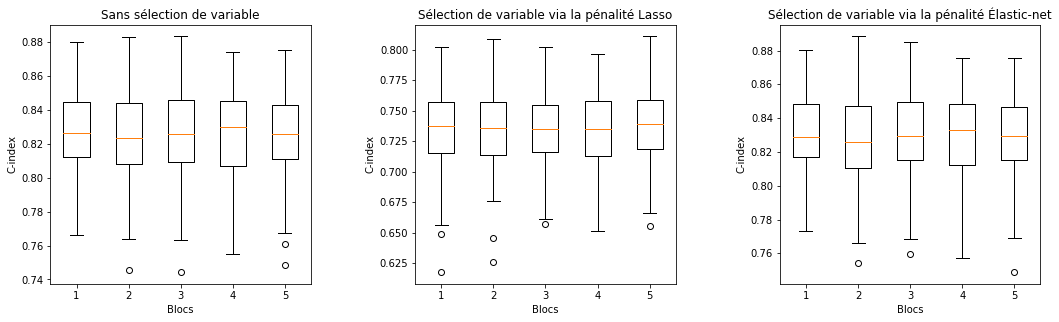

In [ ]:
# scénario 1
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# sans sélection de variable
plt.subplot(1,3,1)
KFold1_scen1, KFold2_scen1, KFold3_scen1, KFold4_scen1, KFold5_scen1 = les_KFold(test_score_normal1)
plt.boxplot([KFold1_scen1, KFold2_scen1, KFold3_scen1, KFold4_scen1, KFold5_scen1])
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Lasso
plt.subplot(1,3,2)
KFold1_lasso_scen1, KFold2_lasso_scen1, KFold3_lasso_scen1, KFold4_lasso_scen1, KFold5_lasso_scen1 = les_KFold(test_score_lasso1)
plt.boxplot([KFold1_lasso_scen1, KFold2_lasso_scen1, KFold3_lasso_scen1, KFold4_lasso_scen1, KFold5_lasso_scen1])
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic-net 
plt.subplot(1,3,3)
KFold1_elastic_scen1, KFold2_elastic_scen1, KFold3_elastic_scen1, KFold4_elastic_scen1, KFold5_elastic_scen1 = les_KFold(test_score_elastic_net1)
plt.boxplot([KFold1_elastic_scen1, KFold2_elastic_scen1, KFold3_elastic_scen1, KFold4_elastic_scen1, KFold5_elastic_scen1])
plt.title('Sélection de variable via la pénalité Élastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen1/c-index1.png')

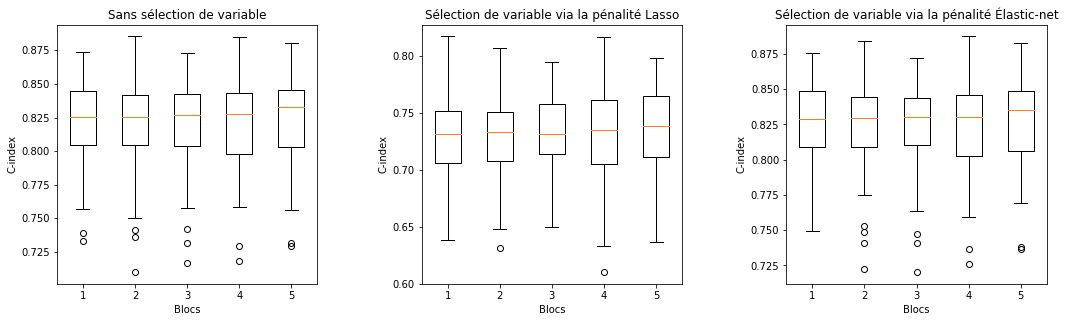

In [ ]:
# scénario 2
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# sans sélection de variable
plt.subplot(1,3,1)
KFold1_scen2, KFold2_scen2, KFold3_scen2, KFold4_scen2, KFold5_scen2 = les_KFold(test_score_normal2)
plt.boxplot([KFold1_scen2, KFold2_scen2, KFold3_scen2, KFold4_scen2, KFold5_scen2])
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Lasso
plt.subplot(1,3,2)
KFold1_lasso_scen2, KFold2_lasso_scen2, KFold3_lasso_scen2, KFold4_lasso_scen2, KFold5_lasso_scen2 = les_KFold(test_score_lasso2)
plt.boxplot([KFold1_lasso_scen2, KFold2_lasso_scen2, KFold3_lasso_scen2, KFold4_lasso_scen2, KFold5_lasso_scen2])
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic-net 
plt.subplot(1,3,3)
KFold1_elastic_scen2, KFold2_elastic_scen2, KFold3_elastic_scen2, KFold4_elastic_scen2, KFold5_elastic_scen2 = les_KFold(test_score_elastic_net2)
plt.boxplot([KFold1_elastic_scen2, KFold2_elastic_scen2, KFold3_elastic_scen2, KFold4_elastic_scen2, KFold5_elastic_scen2])
plt.title('Sélection de variable via la pénalité Élastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')

plt.savefig('drive/MyDrive/save_data/C-index/scen2/c-index2.png')

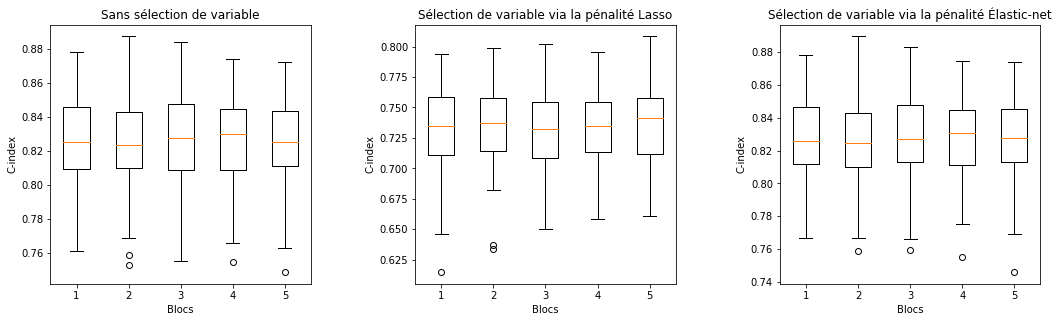

In [ ]:
# scénario 3
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# sans sélection de variable
plt.subplot(1,3,1)
KFold1_scen3, KFold2_scen3, KFold3_scen3, KFold4_scen3, KFold5_scen3 = les_KFold(test_score_normal3)
plt.boxplot([KFold1_scen3, KFold2_scen3, KFold3_scen3, KFold4_scen3, KFold5_scen3])
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Lasso
plt.subplot(1,3,2)
KFold1_lasso_scen3, KFold2_lasso_scen3, KFold3_lasso_scen3, KFold4_lasso_scen3, KFold5_lasso_scen3 = les_KFold(test_score_lasso3)
plt.boxplot([KFold1_lasso_scen3, KFold2_lasso_scen3, KFold3_lasso_scen3, KFold4_lasso_scen3, KFold5_lasso_scen3])
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic-net 
plt.subplot(1,3,3)
KFold1_elastic_scen3, KFold2_elastic_scen3, KFold3_elastic_scen3, KFold4_elastic_scen3, KFold5_elastic_scen3 = les_KFold(test_score_elastic_net3)
plt.boxplot([KFold1_elastic_scen3, KFold2_elastic_scen3, KFold3_elastic_scen3, KFold4_elastic_scen3, KFold5_elastic_scen3])
plt.title('Sélection de variable via la pénalité Élastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')


plt.savefig('drive/MyDrive/save_data/C-index/scen3/c-index3.png')

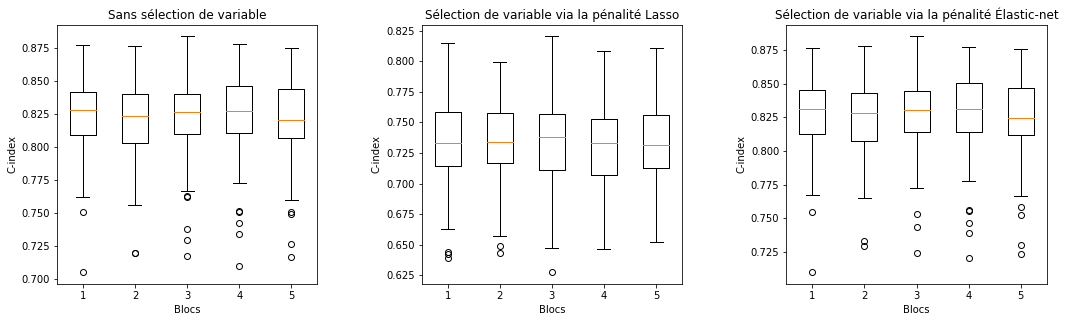

In [ ]:
# scénario 4
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# sans sélection de variable
plt.subplot(1,3,1)
KFold1_scen4, KFold2_scen4, KFold3_scen4, KFold4_scen4, KFold5_scen4 = les_KFold(test_score_normal4)
plt.boxplot([KFold1_scen4, KFold2_scen4, KFold3_scen4, KFold4_scen4, KFold5_scen4])
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Lasso
plt.subplot(1,3,2)
KFold1_lasso_scen4, KFold2_lasso_scen4, KFold3_lasso_scen4, KFold4_lasso_scen4, KFold5_lasso_scen4 = les_KFold(test_score_lasso4)
plt.boxplot([KFold1_lasso_scen4, KFold2_lasso_scen4, KFold3_lasso_scen4, KFold4_lasso_scen4, KFold5_lasso_scen4])
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic-net 
plt.subplot(1,3,3)
KFold1_elastic_scen4, KFold2_elastic_scen4, KFold3_elastic_scen4, KFold4_elastic_scen4, KFold5_elastic_scen4 = les_KFold(test_score_elastic_net4)
plt.boxplot([KFold1_elastic_scen4, KFold2_elastic_scen4, KFold3_elastic_scen4, KFold4_elastic_scen4, KFold5_elastic_scen4])
plt.title('Sélection de variable via la pénalité Élastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')


plt.savefig('drive/MyDrive/save_data/C-index/scen4/c-index4.png')

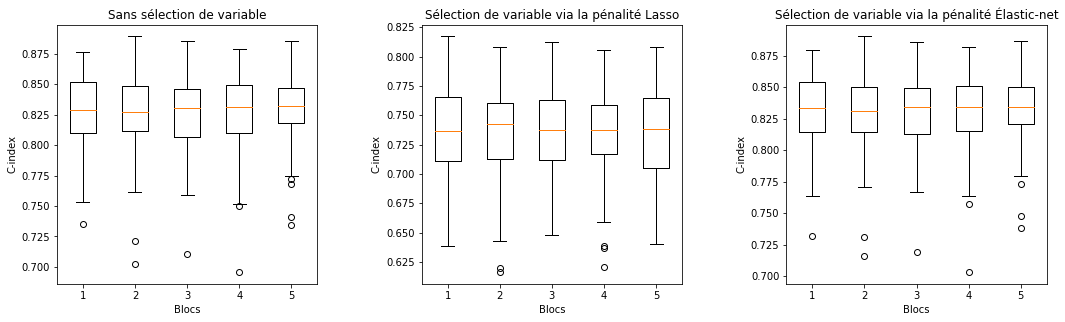

In [ ]:
# scénario 5
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# sans sélection de variable
plt.subplot(1,3,1)
KFold1_scen5, KFold2_scen5, KFold3_scen5, KFold4_scen5, KFold5_scen5 = les_KFold(test_score_normal5)
plt.boxplot([KFold1_scen5, KFold2_scen5, KFold3_scen5, KFold4_scen5, KFold5_scen5])
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Lasso
plt.subplot(1,3,2)
KFold1_lasso_scen5, KFold2_lasso_scen5, KFold3_lasso_scen5, KFold4_lasso_scen5, KFold5_lasso_scen5 = les_KFold(test_score_lasso5)
plt.boxplot([KFold1_lasso_scen5, KFold2_lasso_scen5, KFold3_lasso_scen5, KFold4_lasso_scen5, KFold5_lasso_scen5])
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic-net 
plt.subplot(1,3,3)
KFold1_elastic_scen5, KFold2_elastic_scen5, KFold3_elastic_scen5, KFold4_elastic_scen5, KFold5_elastic_scen5 = les_KFold(test_score_elastic_net5)
plt.boxplot([KFold1_elastic_scen5, KFold2_elastic_scen5, KFold3_elastic_scen5, KFold4_elastic_scen5, KFold5_elastic_scen5])
plt.title('Sélection de variable via la pénalité Élastic-net')
plt.xlabel('Blocs')
plt.ylabel('C-index')


plt.savefig('drive/MyDrive/save_data/C-index/scen5/c-index5.png')

***Nuage du points du C-index moyen en fonction des paramètres optimisés***

In [19]:
# nuage du points du C-index en fonction des alphas
def plot_c_index_alphas(list_alphas_c_index:list, C_index_mean:list):
  plt.scatter(list_alphas_c_index, C_index_mean)
  plt.title('Nuage de points du C-index en fonction des alphas')
  plt.xlabel('alphas')
  plt.ylabel('C-index')
  plt.show()

In [20]:
# nuage du points du C-index en fonction des lambdas
def plot_c_index_lambdas(list_lambda_c_index_elastic_net:list, C_index_mean:list):
  plt.figure(figsize =(10, 12))
  plt.scatter(list_lambda_c_index_elastic_net, C_index_mean)
  plt.title('Nuage de points du C-index en fonction du lambda')
  plt.xlabel('lambda')
  plt.ylabel('C-index')
  plt.show()

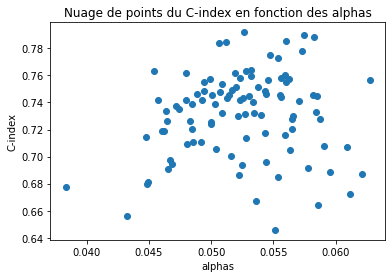

In [ ]:
# scénario 2
# Lasso
plot_c_index_alphas(list_alphas_c_index_lasso2, c_index_mean2)

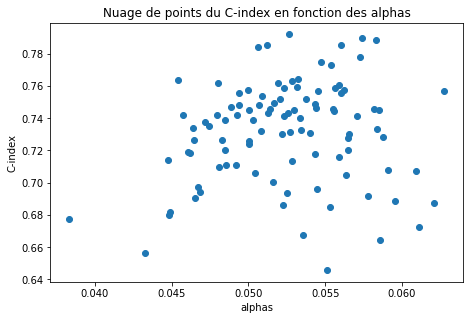

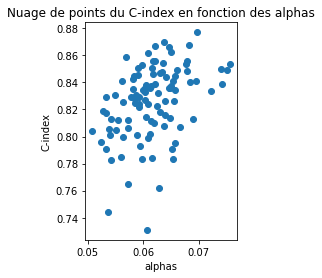

Text(0, 0.5, 'C-index')

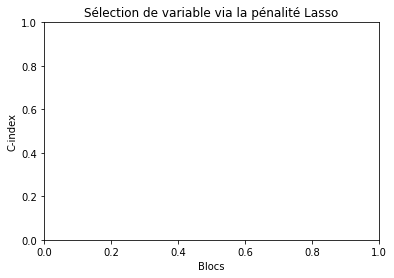

In [ ]:
plt.figure(1,figsize=(10,12))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.5, wspace = 0.4, hspace = 0)

# avec Lasso
plt.subplot(1,2,1)
plot_c_index_alphas(list_alphas_c_index_lasso2, c_index_mean2)
plt.title('Sans sélection de variable')
plt.xlabel('Blocs')
plt.ylabel('C-index')

# avec Elastic net
plt.subplot(1,2,2)
plot_c_index_alphas(list_alphas_c_index_elastic_net2, c_index_mean_elastic_net2)
plt.title('Sélection de variable via la pénalité Lasso')
plt.xlabel('Blocs')
plt.ylabel('C-index')

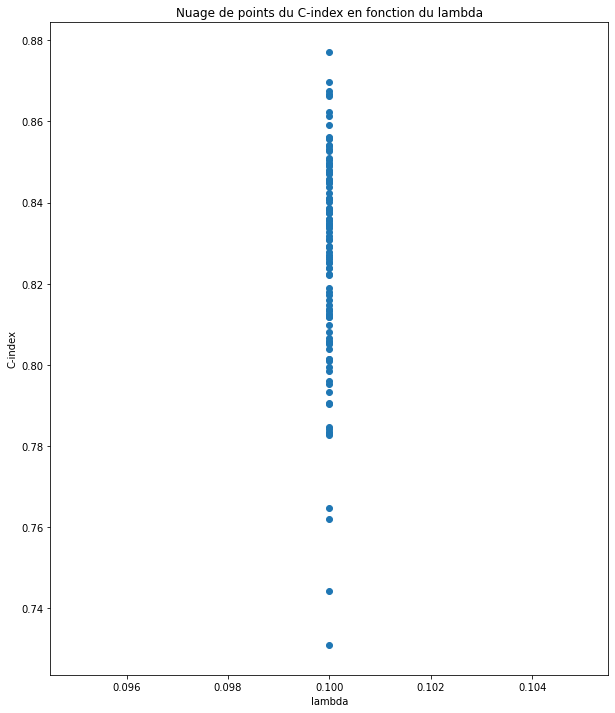

In [ ]:
# scénario 2
# Elastic-net
plot_c_index_lambdas(list_lambda_c_index_elastic_net2, c_index_mean_elastic_net2)

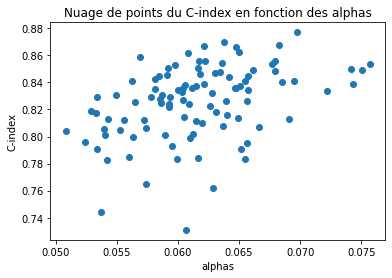

In [ ]:
# Elastic-net
plot_c_index_alphas(list_alphas_c_index_elastic_net2, c_index_mean_elastic_net2)

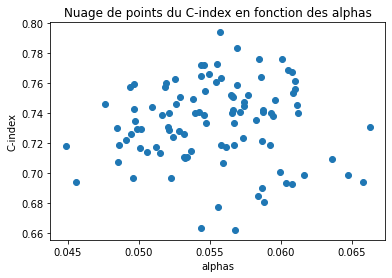

In [21]:
# scénario 3
# Lasso
plot_c_index_alphas(list_alphas_c_index_lasso3, c_index_mean3)

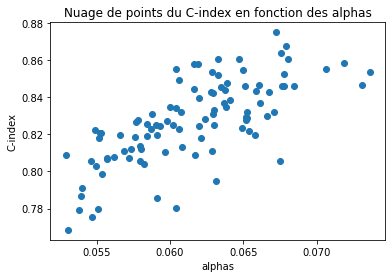

In [ ]:
# Elastic-net
plot_c_index_alphas(list_alphas_c_index_elastic_net3, c_index_mean_elastic_net3)

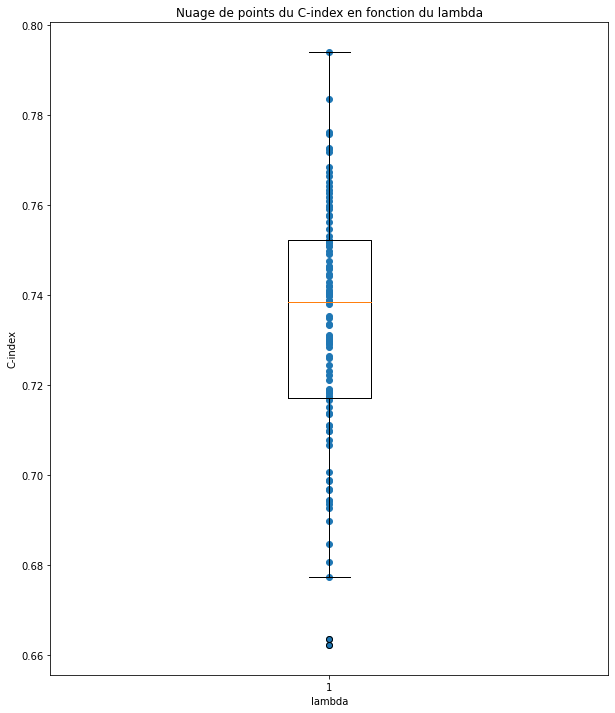

In [ ]:
# Elastic-net
plot_c_index_lambdas(c_index_mean3)

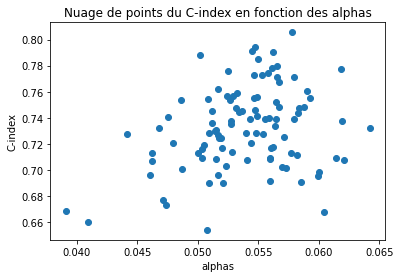

In [22]:
# scénario 4
# Lasso
plot_c_index_alphas(list_alphas_c_index_lasso4, c_index_mean4)

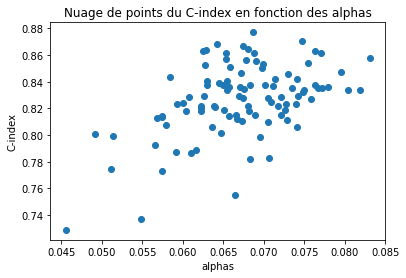

In [ ]:
# Elastic-net
plot_c_index_alphas(list_alphas_c_index_elastic_net4, c_index_mean_elastic_net4)

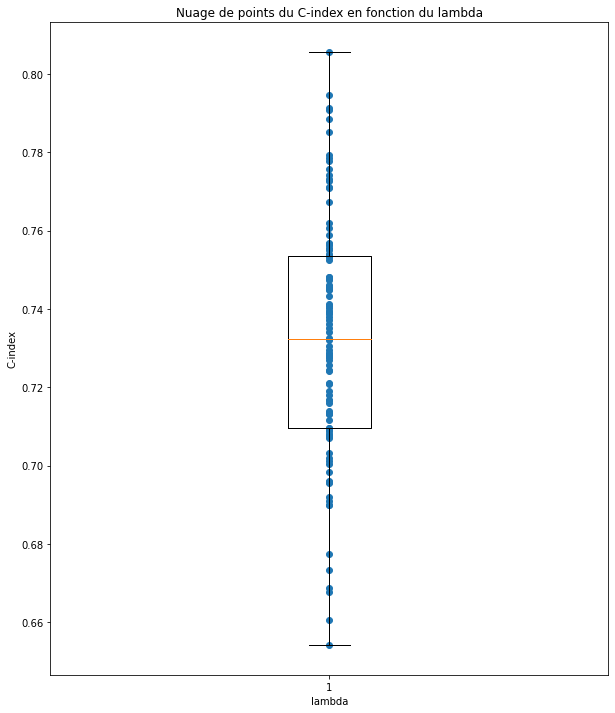

In [ ]:
# Elastic-net
plot_c_index_lambdas(c_index_mean4)

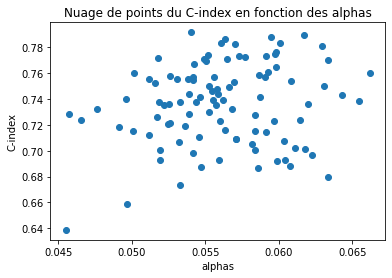

In [23]:
# scénario 5
# Lasso
plot_c_index_alphas(list_alphas_c_index_lasso5, c_index_mean5)

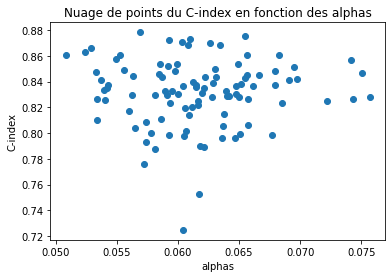

In [ ]:
# Elastic-net
plot_c_index_alphas(list_alphas_c_index_elastic_net5, c_index_mean_elastic_net5)

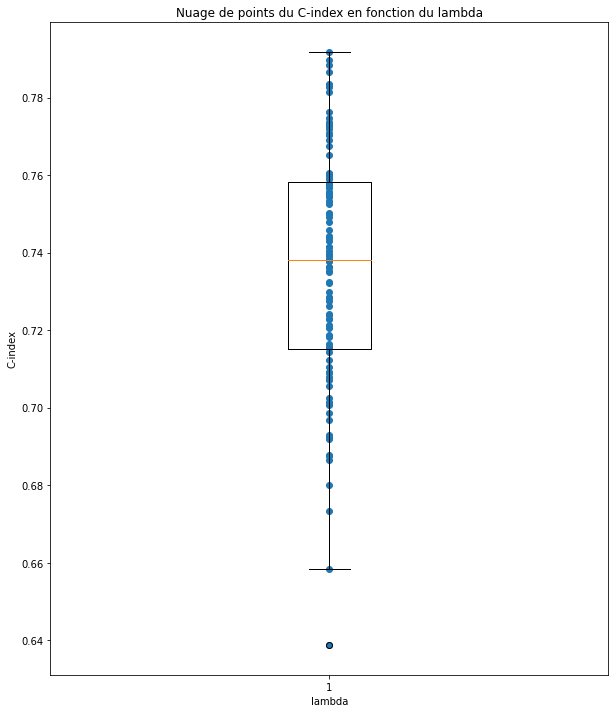

In [ ]:
# Elastic-net
plot_c_index_lambdas(c_index_mean5)